<a href="https://colab.research.google.com/github/insyspo/institutional_collaboration/blob/main/Hierarchy_of_institutional_collaboration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install igraph
!pip install leidenalg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.3 MB/s eta 0:00:00


In [5]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

Authenticated


In [8]:
from google.colab import drive
drive.mount('/content/drive')
folder = '/content/drive/My Drive/Colaboração/Institutional collaboration/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
from igraph import Graph
import igraph as ig
import pandas as pd
import leidenalg as la
import numpy as np
import pandas_gbq
import glob
from google.cloud import bigquery
import matplotlib.pyplot as plt

In [45]:
# engineering = 22
# physics = 31
# medicine = 27
# computing = 17

area_codes = [22,31,27,17]
areas = ['Engineering','Physics','Medicine','Computing']
selected = 0
area = areas[selected]
area_code = area_codes[selected]

In [50]:
client = bigquery.Client(project='insypo')
job = client.query('''
  DROP TABLE IF EXISTS projectdb_institutional_collaboration.works_fields;
  CREATE TABLE projectdb_institutional_collaboration.works_fields AS (
    SELECT DISTINCT a.work_id, c.publication_year
    FROM `insyspo.publicdb_openalex_2025_03_rm.works_topics` AS a
    JOIN `insyspo.publicdb_openalex_2025_03_rm.topics` AS b
    ON a.topic_id = b.id
    JOIN `insyspo.publicdb_openalex_2025_03_rm.works` AS c
    ON a.work_id = c.id
    WHERE b.field = %s AND publication_year >= 1990 AND c.type = 'article'
      AND a.score >= 0.9
  );
''' % (str(area_code)),project='insyspo')
print(job)

QueryJob<project=insyspo, location=US, id=88e3d245-0286-47bf-9053-0a92c09150d9>


In [52]:
%%bigquery --project insyspo

CREATE OR REPLACE TABLE projectdb_institutional_collaboration.relevant_institutions AS (
  SELECT DISTINCT c.*
  FROM projectdb_institutional_collaboration.works_fields AS a
  JOIN `insyspo.publicdb_openalex_2025_03_rm.works_authorships` AS b
  ON a.work_id = b.work_id
  JOIN `insyspo.publicdb_openalex_2025_03_rm.institutions` AS c
  ON b.institution_id = c.id
  WHERE c.works_count > 10
)

Query is running:   0%|          |

""


In [53]:
%%bigquery --project insyspo

CREATE OR REPLACE TABLE projectdb_institutional_collaboration.relevant_institutions_works AS (
  SELECT d.id, COUNT(DISTINCT(a.work_id)) AS n
  FROM projectdb_institutional_collaboration.works_fields AS a
  JOIN `insyspo.publicdb_openalex_2025_03_rm.works_authorships` AS b
  ON a.work_id = b.work_id
  JOIN `insyspo.publicdb_openalex_2025_03_rm.institutions` AS c
  ON b.institution_id = c.id
  JOIN projectdb_institutional_collaboration.relevant_institutions AS d
  ON c.id = d.id
  GROUP BY d.id
)

Query is running:   0%|          |

""


In [54]:
%%bigquery --project insyspo

CREATE OR REPLACE TABLE projectdb_institutional_collaboration.relevant_institutions_filtered_largest AS (
  SELECT id
  FROM (
    SELECT *,
      NTILE(100) OVER (ORDER BY n DESC) AS ptile,
    FROM projectdb_institutional_collaboration.relevant_institutions_works
    ORDER BY n DESC
  )
  WHERE ptile <= 10
);

CREATE OR REPLACE TABLE projectdb_institutional_collaboration.relevant_institutions_filtered_smallest AS (
  SELECT id
  FROM (
    SELECT *,
      NTILE(100) OVER (ORDER BY n DESC) AS ptile,
    FROM projectdb_institutional_collaboration.relevant_institutions_works
    ORDER BY n DESC
  )
  WHERE ptile > 10 AND n>10
);

Query is running:   0%|          |

""


In [55]:
%%bigquery --project insyspo

CREATE OR REPLACE TABLE projectdb_institutional_collaboration.works_authorships_large AS (
  SELECT b.*
  FROM projectdb_institutional_collaboration.relevant_institutions_filtered_largest AS a
  JOIN `insyspo.publicdb_openalex_2025_03_rm.works_authorships` AS b
  ON a.id = b.institution_id
);

CREATE OR REPLACE TABLE projectdb_institutional_collaboration.works_authorships_small AS (
  SELECT b.*
  FROM projectdb_institutional_collaboration.relevant_institutions_filtered_smallest AS a
  JOIN `insyspo.publicdb_openalex_2025_03_rm.works_authorships` AS b
  ON a.id = b.institution_id
);

Query is running:   0%|          |

""


In [56]:
%%bigquery --project insyspo

DROP TABLE IF EXISTS projectdb_institutional_collaboration.insts_colabs_large;
CREATE TABLE projectdb_institutional_collaboration.insts_colabs_large AS (
  SELECT b.institution_id AS insta,
    c.institution_id AS instb, COUNT(DISTINCT(a.work_id)) AS works
  FROM `insyspo.projectdb_institutional_collaboration.works_fields` AS a
  JOIN `projectdb_institutional_collaboration.works_authorships_large` AS b
  ON a.work_id = b.work_id
  JOIN `projectdb_institutional_collaboration.works_authorships_large` AS c
  ON a.work_id = c.work_id
  WHERE b.institution_id > c.institution_id
  GROUP BY b.institution_id, c.institution_id
);

DROP TABLE IF EXISTS projectdb_institutional_collaboration.insts_colabs_small;
CREATE TABLE projectdb_institutional_collaboration.insts_colabs_small AS (
  SELECT b.institution_id AS insta,
    c.institution_id AS instb, COUNT(DISTINCT(a.work_id)) AS works
  FROM `insyspo.projectdb_institutional_collaboration.works_fields` AS a
  JOIN `projectdb_institutional_collaboration.works_authorships_small` AS b
  ON a.work_id = b.work_id
  JOIN `projectdb_institutional_collaboration.works_authorships_small` AS c
  ON a.work_id = c.work_id
  WHERE b.institution_id > c.institution_id
  GROUP BY b.institution_id, c.institution_id
);

Query is running:   0%|          |

""


In [57]:
%%bigquery --project insyspo

DROP TABLE IF EXISTS projectdb_institutional_collaboration.insts_colabs_year_large;
CREATE TABLE projectdb_institutional_collaboration.insts_colabs_year_large AS (
  SELECT b.institution_id AS inst1,
    c.institution_id AS inst2,
    a.publication_year
  FROM `insyspo.projectdb_institutional_collaboration.works_fields` AS a
  JOIN `projectdb_institutional_collaboration.works_authorships_large` AS b
  ON a.work_id = b.work_id
  JOIN `projectdb_institutional_collaboration.works_authorships_large` AS c
  ON a.work_id = c.work_id
  WHERE b.institution_id > c.institution_id
  GROUP BY b.institution_id, c.institution_id, a.publication_year
);

DROP TABLE IF EXISTS projectdb_institutional_collaboration.insts_colabs_year_small;
CREATE TABLE projectdb_institutional_collaboration.insts_colabs_year_small AS (
  SELECT b.institution_id AS inst1,
    c.institution_id AS inst2,
    a.publication_year
  FROM `insyspo.projectdb_institutional_collaboration.works_fields` AS a
  JOIN `projectdb_institutional_collaboration.works_authorships_small` AS b
  ON a.work_id = b.work_id
  JOIN `projectdb_institutional_collaboration.works_authorships_small` AS c
  ON a.work_id = c.work_id
  WHERE b.institution_id > c.institution_id
  GROUP BY b.institution_id, c.institution_id, a.publication_year
);

Query is running:   0%|          |

""


In [58]:
%%bigquery --project insyspo

SELECT *
FROM projectdb_institutional_collaboration.insts_colabs_year_small
LIMIT 50

Query is running:   0%|          |

Downloading:   0%|          |

,inst1,inst2,publication_year
0,24927338,1141210,1990
1,27559774,5444425,1990
2,31586040,195165,1990
3,35566140,20486536,1990
4,59081768,23151741,1990
5,72019824,39660569,1990
6,79839527,22675022,1990
7,81726945,6048146,1990
8,84381889,36253440,1990
9,85324120,55881946,1990


# Networks' analysis

In [59]:
!pip install igraph
!pip install leidenalg

In [60]:
import pandas as pd
import pandas_gbq as pgbq
import igraph as ig
import matplotlib.pyplot as plt

In [61]:
intervals = [1990, 2000, 2010]
di = 10
G = [[],[],[]]

connections =  pd.DataFrame({'inst1': [],
                                'inst2': [],
                                'weight': [],
                                'interval': []})

connections['inst1'] = connections['inst1'].astype(int)
connections['inst2'] = connections['inst2'].astype(int)
connections['interval'] = connections['interval'].astype(int)
connections['weight'] = connections['weight'].astype(float)

for ci, i in enumerate(intervals):
  query = '''
  SELECT inst1, inst2,
    COUNT(*)/(
        SELECT COUNT(*)
        FROM insyspo.projectdb_institutional_collaboration.insts_colabs_year
        WHERE publication_year >= {0} AND publication_year < {1}
    ) AS weight
  FROM insyspo.projectdb_institutional_collaboration.insts_colabs_year
  WHERE publication_year >= {0} AND publication_year < {1} AND inst1 > inst2
  GROUP BY inst1, inst2
  '''.format(i,i+di)
  df = pd.read_gbq(query,project_id = 'insyspo')

  tuples = [tuple(x) for x in df.values]
  G[ci] = ig.Graph.TupleList(tuples, directed = False)

<ipython-input-61-3739ab2328ec>:27: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query,project_id = 'insyspo')
<ipython-input-61-3739ab2328ec>:27: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query,project_id = 'insyspo')
<ipython-input-61-3739ab2328ec>:27: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query,project_id = 'insyspo')


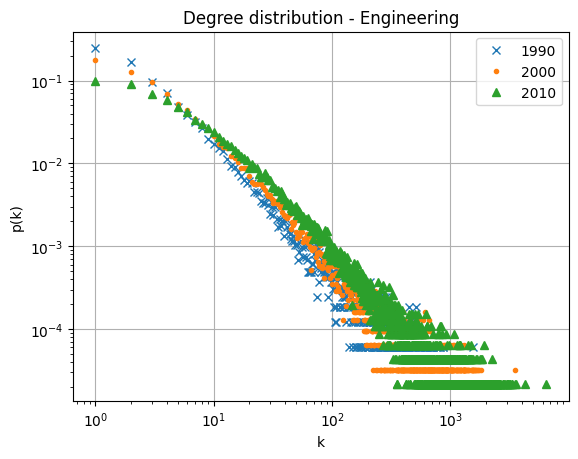

In [62]:
g1 = G[0]
g2 = G[1]
g3 = G[2]

degreeList1 = g1.degree()
degreeList2 = g2.degree()
degreeList3 = g3.degree()

markers = ['x', '.', '^']
labels = ['1990', '2000', '2010']

for degreeList, marker, label in zip([degreeList1, degreeList2, degreeList3], markers, labels):
    densityList = []
    degreeL = []

    for degree in set(degreeList):
        contagem = degreeList.count(degree)
        density = contagem / len(degreeList)
        degreeL.append(degree)
        densityList.append(density)
    plt.loglog(degreeL, densityList, marker=marker, linestyle='',\
               label=label)

plt.xlabel('k')
plt.ylabel('p(k)')
plt.legend()
plt.title('Degree distribution - '+area)
plt.grid(True)
plt.savefig('degree_distribution_'+area+'.png')

# Hierarchy analysis

##Large institutions

In [ ]:
intervals = [1990, 2000, 2010]
di = 10
Gl = [[],[],[]]

connections =  pd.DataFrame({'inst1': [],
                                'inst2': [],
                                'weight': [],
                                'interval': []})

connections['inst1'] = connections['inst1'].astype(int)
connections['inst2'] = connections['inst2'].astype(int)
connections['interval'] = connections['interval'].astype(int)
connections['weight'] = connections['weight'].astype(float)

for ci, i in enumerate(intervals):
  query = '''
  SELECT inst1, inst2,
    COUNT(*)/(
        SELECT COUNT(*)
        FROM insyspo.projectdb_institutional_collaboration.insts_colabs_year_large
        WHERE publication_year >= {0} AND publication_year < {1}
    ) AS weight
  FROM insyspo.projectdb_institutional_collaboration.insts_colabs_year_large
  WHERE publication_year >= {0} AND publication_year < {1} AND inst1 > inst2
  GROUP BY inst1, inst2
  '''.format(i,i+di)
  df = pd.read_gbq(query,project_id = 'insyspo')

  tuples = [tuple(x) for x in df.values]
  Gl[ci] = ig.Graph.TupleList(tuples, directed = False)

<ipython-input-63-698477ca3093>:27: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query,project_id = 'insyspo')
<ipython-input-63-698477ca3093>:27: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query,project_id = 'insyspo')
<ipython-input-63-698477ca3093>:27: FutureWarning: read_gbq is deprecated and will be removed in a future version. Please use pandas_gbq.read_gbq instead: https://pandas-gbq.readthedocs.io/en/latest/api.html#pandas_gbq.read_gbq
  df = pd.read_gbq(query,project_id = 'insyspo')


In [ ]:
g1 = Gl[0]
g2 = Gl[1]
g3 = Gl[2]

degreeList1 = g1.degree()
degreeList2 = g2.degree()
degreeList3 = g3.degree()

markers = ['x', '.', '^']
labels = ['1990', '2000', '2010']

for degreeList, marker, label in zip([degreeList1, degreeList2, degreeList3], markers, labels):
    densityList = []
    degreeL = []

    for degree in set(degreeList):
        contagem = degreeList.count(degree)
        density = contagem / len(degreeList)
        degreeL.append(degree)
        densityList.append(density)
    plt.loglog(degreeL, densityList, marker=marker, linestyle='',\
               label=label)

plt.xlabel('k')
plt.ylabel('p(k)')
plt.legend()
plt.title('Degree distribution - '+area+' - large institutions')
plt.grid(True)
plt.savefig('degree_distribution_'+area+'_large.png')

## Small institutions

In [ ]:
intervals = [1990, 2000, 2010]
di = 10
Gs = [[],[],[]]

connections =  pd.DataFrame({'inst1': [],
                                'inst2': [],
                                'weight': [],
                                'interval': []})

connections['inst1'] = connections['inst1'].astype(int)
connections['inst2'] = connections['inst2'].astype(int)
connections['interval'] = connections['interval'].astype(int)
connections['weight'] = connections['weight'].astype(float)

for ci, i in enumerate(intervals):
  query = '''
  SELECT inst1, inst2,
    COUNT(*)/(
        SELECT COUNT(*)
        FROM insyspo.projectdb_institutional_collaboration.insts_colabs_year_small
        WHERE publication_year >= {0} AND publication_year < {1}
    ) AS weight
  FROM insyspo.projectdb_institutional_collaboration.insts_colabs_year_small
  WHERE publication_year >= {0} AND publication_year < {1} AND inst1 > inst2
  GROUP BY inst1, inst2
  '''.format(i,i+di)
  df = pd.read_gbq(query,project_id = 'insyspo')

  tuples = [tuple(x) for x in df.values]
  Gs[ci] = ig.Graph.TupleList(tuples, directed = False)

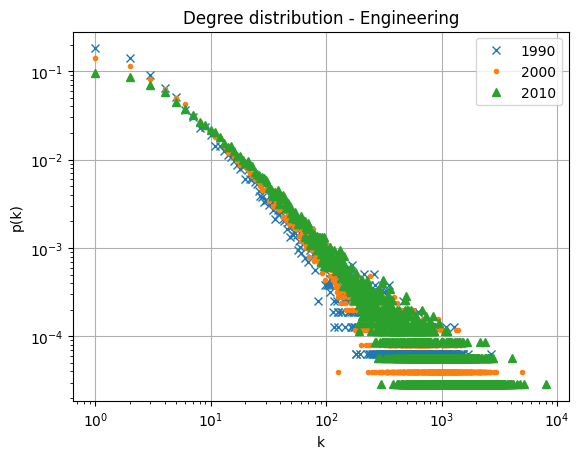

In [ ]:
g1 = Gs[0]
g2 = Gs[1]
g3 = Gs[2]

degreeList1 = g1.degree()
degreeList2 = g2.degree()
degreeList3 = g3.degree()

markers = ['x', '.', '^']
labels = ['1990', '2000', '2010']

for degreeList, marker, label in zip([degreeList1, degreeList2, degreeList3], markers, labels):
    densityList = []
    degreeL = []

    for degree in set(degreeList):
        contagem = degreeList.count(degree)
        density = contagem / len(degreeList)
        degreeL.append(degree)
        densityList.append(density)
    plt.loglog(degreeL, densityList, marker=marker, linestyle='',\
               label=label)

plt.xlabel('k')
plt.ylabel('p(k)')
plt.legend()
plt.title('Degree distribution - '+area+' - small institutions')
plt.grid(True)
plt.savefig('degree_distribution_'+area+'_small.png')